In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10'
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(N

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [14]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 5e-4
optimizer_config['weight_decay'] = 1e-4
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [15]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config

{'aug_type': 'soft', 'original_height': 128, 'original_width': 128, 'k': 1}

In [16]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 0.6, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 0.4, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 0.5, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 0.5,
  'params': {'mode': 'multiclass',
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [17]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [18]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 712.89it/s]
100%|██████████| 720/720 [00:07<00:00, 94.40it/s] 
8280it [00:00, 256178.49it/s]
7920it [00:00, 240685.18it/s]
700it [00:00, 858.20it/s]
100%|██████████| 700/700 [00:06<00:00, 107.89it/s]
8280it [00:00, 248775.69it/s]
7920it [00:00, 234061.10it/s]
710it [00:00, 830.66it/s]
100%|██████████| 710/710 [00:06<00:00, 103.78it/s]
7920it [00:00, 83988.52it/s]
7560it [00:00, 245453.72it/s]
720it [00:00, 815.82it/s]
100%|██████████| 720/720 [00:07<00:00, 95.12it/s] 
8280it [00:00, 250496.52it/s]
720it [00:00, 833.87it/s]
100%|██████████| 720/720 [00:07<00:00, 94.21it/s] 
25920it [00:00, 134672.29it/s]
700it [00:00, 812.18it/s]
100%|██████████| 700/700 [00:06<00:00, 107.01it/s]
25200it [00:00, 124428.41it/s]
509it [00:00, 1145.00it/s]
100%|██████████| 509/509 [00:02<00:00, 196.63it/s]
8144it [00:00, 228715.37it/s]
700it [00:00, 819.77it/s]
100%|██████████| 700/700 [00:07<00:00, 99.84it/s] 
25200it [00:00, 228804.49it/s]
700it [00:00, 815.53it/s]
100%|██████████| 700/700 

In [19]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [20]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [21]:
device = 'cuda:1'
# device = 'cpu'

In [22]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [23]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [24]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [25]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.075845


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.032011
Epoch 1...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028844


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.034888
EarlyStopping counter: 1 out of 10
Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02529


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036476
EarlyStopping counter: 2 out of 10
Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.023458


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.026617
Epoch 4...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.022502


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.045643
EarlyStopping counter: 1 out of 10
Epoch 5...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02179


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.029884
EarlyStopping counter: 2 out of 10
Epoch 6...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021329


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.022377
Epoch 7...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021108


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.025388
EarlyStopping counter: 1 out of 10
Epoch 8...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020801


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.021361
Epoch 9...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02046


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.021391
EarlyStopping counter: 1 out of 10
Epoch 10...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020207


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.021364
Epoch 11...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020037


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.021045
Epoch 12...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019739


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.021827
EarlyStopping counter: 1 out of 10
Epoch 13...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019665


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020636
Epoch 14...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019549


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.02281
EarlyStopping counter: 1 out of 10
Epoch 15...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019427


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020013
Epoch 16...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019413


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020653
EarlyStopping counter: 1 out of 10
Epoch 17...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019099


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020141
EarlyStopping counter: 2 out of 10
Epoch 18...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019078


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020077
EarlyStopping counter: 3 out of 10
Epoch 19...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018998


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020085
EarlyStopping counter: 4 out of 10
Epoch 20...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018861


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.02061
EarlyStopping counter: 5 out of 10
Epoch 21...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018765


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020303
EarlyStopping counter: 6 out of 10
Epoch 22...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018678


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.021121
EarlyStopping counter: 7 out of 10
Epoch 23...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018614


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.022759
EarlyStopping counter: 8 out of 10
Epoch 24...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018617


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020238
EarlyStopping counter: 9 out of 10
Epoch 25...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018588


  0%|          | 0/259 [00:00<?, ?it/s]

Mean val loss: 0.020144
EarlyStopping counter: 10 out of 10


100%|██████████| 788/788 [08:37<00:00,  1.52it/s]


## Dump experiment results

In [26]:
import pickle
import json

In [27]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [28]:
from itertools import chain

In [29]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [30]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

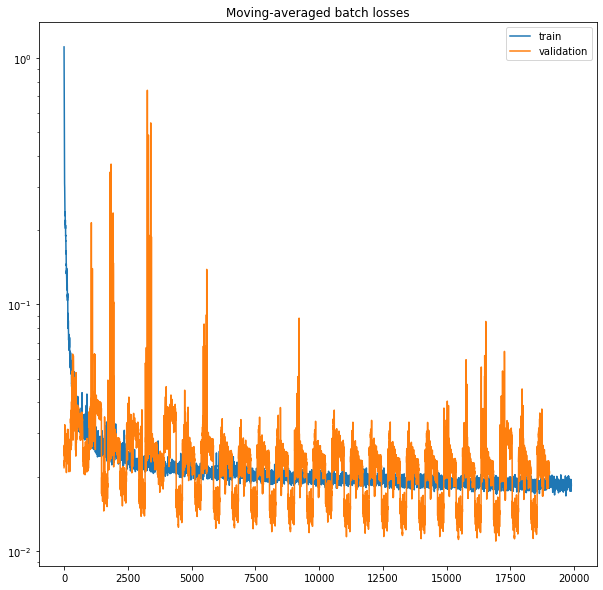

In [31]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [32]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

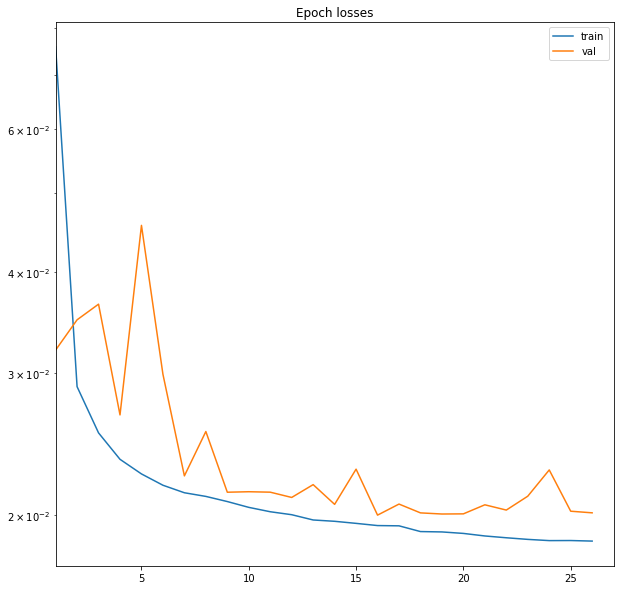

In [33]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [34]:
import pandas as pd

In [35]:
from visualization_utils import make_df

In [36]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.995806,0.951010,0.994419,0.972230,0.998314,0.945961,carb96558,basic
1,0.985991,0.899838,0.996222,0.945580,0.994028,0.896778,carb71,basic
2,0.982475,0.952979,0.892699,0.921855,0.976534,0.855038,carbRNF,basic
3,0.993397,0.991845,0.939176,0.964792,0.997129,0.931979,SPE_carb10_58_box3,basic
4,0.992870,0.961300,0.945436,0.953302,0.993518,0.910771,SoilAh-1,basic
5,0.994728,0.931818,0.989024,0.959569,0.996714,0.922281,SoilB-2,basic
6,0.990270,0.994575,0.935615,0.964194,0.993994,0.930864,TeTree_subset1,basic
7,0.994558,0.992849,0.956241,0.974201,0.996484,0.949700,TiTree_subset2,basic
8,0.991130,0.940851,0.993146,0.966292,0.997576,0.934782,Urna_22,basic
9,0.989204,0.952254,0.985959,0.968813,0.997803,0.939513,Urna_30,basic


In [37]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91995
Std    IOU: 0.027564
Min    IOU: 0.85504
Median IOU: 0.93086


## Check loss to loss ratio

In [40]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [3]:
from stack_segmentation.training import make_joint_loss

In [46]:
import torch

In [70]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

[{'loss': 'BCE', 'weight': 0.5, 'params': {}},
 {'loss': 'Dice',
  'weight': 0.5,
  'params': {'mode': 'multiclass',
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [67]:
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [71]:
print('Mean 0 loss: {:.4f}\nMEan 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0050
MEan 1 loss: 0.0088
Mean of ratios: 0.6099
Ratio of means: 0.5694
